In [40]:
import sklearn
from sklearn.linear_model import Ridge
import time
from scipy.io import loadmat
import scipy.io
import functionList
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

In [41]:
raw = loadmat(r"C:\Users\parkf\Desktop\summer2021\eegData\for_Barry\457B.mat") #change this to try different one off files
X = raw['data']   #[0][0]['data'] #file format is different from ###L/R.mat vs the sample data
mask = raw['mask']
l = X.shape[0]

In [42]:
#holdStack = X
#for i in range(9):
#    X = np.hstack((X,holdStack))

In [43]:
memVec = [4, 8, 16, 20]
ridgeVec = [.1, .5, 1, 10]
ridgeVecNormal = np.dot(ridgeVec,l)
cvNum = 3

s = (len(memVec),len(ridgeVec),cvNum)
error = np.zeros(s)
runTimes = np.zeros(s)
for memNumber in memVec:
    featureMat = functionList.buildFeatureMat(X,memNumber)
    xClean = functionList.removeTrash(X,mask,memNumber)
    featureMat = functionList.removeTrash(featureMat,mask,memNumber)
    #saveThis = {"dataToCheck": featureMat} #to save as a matlab file to check the cleaning function
    #scipy.io.savemat("checkClean.mat",saveThis)
    for regularizer in ridgeVecNormal: 
        RR = Ridge(alpha=regularizer)
        crossVal = sklearn.model_selection.KFold(n_splits=cvNum)
        cvRun = 0
        for train, test in crossVal.split(featureMat):
            start = time.time()
            RR.fit(featureMat[train,:],xClean[train])
            end = time.time()
            pred = RR.predict(featureMat[test])
            error[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] = error[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] + functionList.findMSE(pred, xClean[test])
            runTimes[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] = end - start
            cvRun = cvRun + 1


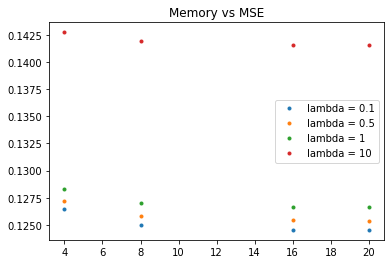

In [44]:
plt.title("Memory vs MSE") #### can update the code below with this type of loop
eAvg = np.sum(error,axis=2)/cvNum
for i in range(len(ridgeVec)):
    plt.plot(memVec[:], eAvg[:,i], ".", label = f"lambda = {ridgeVec[i]}")
plt.legend()
plt.show()

In [45]:
print(runTimes)
print("errors below")
print(error)
#print(np.sum(error,axis=2)/cvNum)

[[[0.84630179 0.79981518 0.83617735]
  [0.79257202 0.83656716 0.95944381]
  [0.82756734 0.76895165 0.92409658]
  [0.8556571  0.82305527 0.90585685]]

 [[1.62982488 1.6260705  1.54539537]
  [1.54711771 1.54867363 1.51122189]
  [1.58706403 1.54152632 1.58279896]
  [1.72365594 1.60716319 1.72619271]]

 [[5.21724701 4.15076661 3.52756667]
  [3.4777298  3.50266314 3.80883765]
  [4.29531407 4.38361883 4.53929687]
  [6.22552347 5.33628201 5.08213854]]

 [[7.35283089 6.07665229 6.0578804 ]
  [6.02947712 6.63875103 7.66027975]
  [7.334198   7.28371549 7.51926064]
  [7.61353064 7.30362034 6.96960449]]]
errors below
[[[0.12701439 0.12798227 0.12432492]
  [0.12777747 0.12874991 0.12506928]
  [0.12887104 0.12984776 0.12616296]
  [0.14324547 0.14420564 0.14072385]]

 [[0.12552872 0.12663537 0.1227751 ]
  [0.12640919 0.1274986  0.12361678]
  [0.12763106 0.12870033 0.12481624]
  [0.14252537 0.14349554 0.13972647]]

 [[0.12512446 0.12613894 0.12238259]
  [0.12602446 0.12701631 0.12323924]
  [0.12727692

In [46]:
errorGpu = np.zeros(s)
runTimesGpu = np.zeros(s)
for memNumber in memVec:
    featureMat = functionList.buildFeatureMat(X,memNumber)
    xClean = functionList.removeTrash(X,mask,memNumber)
    featureMat = functionList.removeTrash(featureMat,mask,memNumber)
    for regularizer in ridgeVecNormal: 
        crossVal = sklearn.model_selection.KFold(n_splits=cvNum)
        cvRun = 0
        for train, test in crossVal.split(featureMat):
            start = time.time()
            w = functionList.solveRrClosedForm(featureMat[train,:],xClean[train],regularizer)
            end = time.time()
            pred = functionList.predClosedForm(featureMat[test,:],w)
            errorGpu[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] = errorGpu[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] + functionList.findMSE(pred, xClean[test])
            runTimesGpu[memVec.index(memNumber), ridgeVec.index(regularizer/l), cvRun] = end - start
            cvRun = cvRun + 1

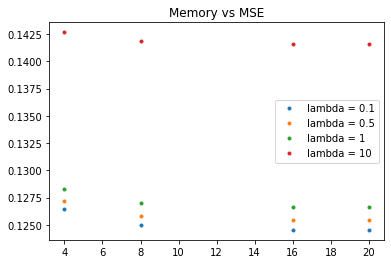

In [47]:
plt.title("Memory vs MSE") #### can update the code below with this type of loop
eAvg = np.sum(errorGpu,axis=2)/cvNum
for i in range(len(ridgeVec)):
    plt.plot(memVec[:], eAvg[:,i], ".", label = f"lambda = {ridgeVec[i]}")
plt.legend()
plt.show()

In [48]:
print(runTimesGpu)
print("errors below")
print(errorGpu)

[[[0.48421216 0.35604811 0.42835736]
  [0.4523387  0.42738295 0.41787887]
  [0.42193055 0.43127608 0.42120552]
  [0.4802897  0.44680023 0.44856   ]]

 [[1.08864069 1.16596007 1.16641426]
  [1.25248551 1.31356025 1.41673398]
  [1.19434071 1.26469517 1.27918625]
  [1.22461605 1.22977757 1.24273372]]

 [[3.49412775 3.35296106 3.39569426]
  [3.32836676 3.29068327 3.37062454]
  [3.25904059 3.27548909 3.34290195]
  [3.37894583 3.49190474 3.38715053]]

 [[5.42381692 4.96378374 4.92395139]
  [4.91943526 5.01970983 4.86006713]
  [4.94466901 4.97944808 4.86492419]
  [5.03207564 5.05480838 4.93842173]]]
errors below
[[[0.12701376 0.12796311 0.12429689]
  [0.12777566 0.12872582 0.12503787]
  [0.12886776 0.1298182  0.12612839]
  [0.14320543 0.14410607 0.14065434]]

 [[0.12552827 0.12662178 0.12276863]
  [0.12640796 0.12748173 0.12360783]
  [0.12762896 0.12867981 0.12480498]
  [0.1425062  0.14342905 0.13968942]]

 [[0.12512387 0.12613089 0.12238509]
  [0.12602336 0.12700618 0.12324016]
  [0.12727531

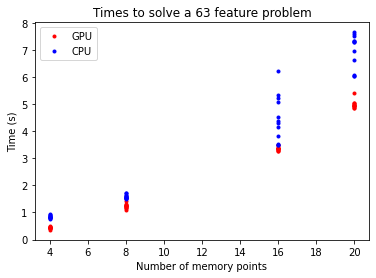

In [49]:
plt.title(f"Times to solve a {X.shape[1]+1} feature problem") #### can update the code below with this type of loop
for i in range(len(ridgeVec)):
    plt.plot(memVec[:], runTimesGpu[:, i, :], ".", color = "r", label = f"GPU")
for i in range(len(ridgeVec)):
    plt.plot(memVec[:], runTimes[:, i, :], ".", color = "b", label = f"CPU")

#stops duplicate labels. from: https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend ecatmur
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.ylabel('Time (s)')
plt.xlabel('Number of memory points')
plt.show()